Starting grid search... This may take a while...
Fitting 5 folds for each of 336 candidates, totalling 1680 fits
[CV] END pca__n_components=0.85, svm__C=0.01, svm__gamma=scale, svm__kernel=rbf; total time=   0.2s[CV] END pca__n_components=0.85, svm__C=0.01, svm__gamma=scale, svm__kernel=rbf; total time=   0.2s

[CV] END pca__n_components=0.85, svm__C=0.01, svm__gamma=scale, svm__kernel=rbf; total time=   0.2s
[CV] END pca__n_components=0.85, svm__C=0.01, svm__gamma=scale, svm__kernel=poly; total time=   0.1s
[CV] END pca__n_components=0.85, svm__C=0.01, svm__gamma=scale, svm__kernel=rbf; total time=   0.2s
[CV] END pca__n_components=0.85, svm__C=0.01, svm__gamma=scale, svm__kernel=rbf; total time=   0.2s
[CV] END pca__n_components=0.85, svm__C=0.01, svm__gamma=scale, svm__kernel=poly; total time=   0.1s
[CV] END pca__n_components=0.85, svm__C=0.01, svm__gamma=scale, svm__kernel=poly; total time=   0.1s
[CV] END pca__n_components=0.85, svm__C=0.01, svm__gamma=scale, svm__kernel=poly; to

<Figure size 1200x1000 with 0 Axes>

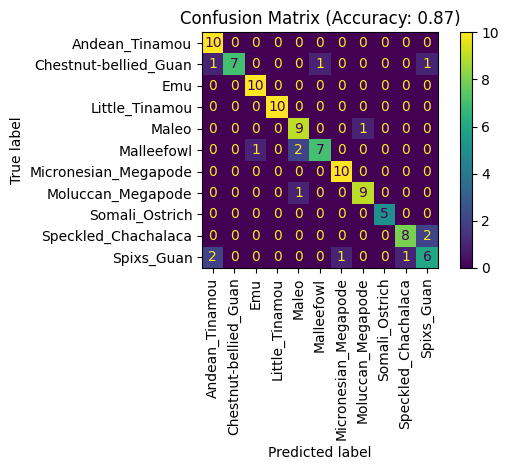


Model training complete!
Best model saved to: models/best_svm_model.pkl
Best test accuracy: 0.8667


In [6]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report, 
                            confusion_matrix, ConfusionMatrixDisplay)
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

BASE_DIR = Path.cwd() if 'notebooks' not in str(Path.cwd()) else Path.cwd().parent

# Ensure the data directory is correctly referenced from the project root
DATA_DIR = BASE_DIR / 'data'
PROCESSED_DATA_DIR = DATA_DIR / 'processed' / 'birdcall_segments_3s'
FEATURES_DIR = DATA_DIR / 'features/bird_features.csv'
# Load the extracted features
features_df = pd.read_csv(FEATURES_DIR)

# Data Preprocessing
# -----------------
# 1. Separate features and labels
X = features_df.drop(['label', 'source_file'], axis=1)
y = features_df['label']

# 2. Handle missing values
X.fillna(X.mean(), inplace=True)

# 3. Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 4. Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# SVM Pipeline with Optimization
# -----------------------------
# Create a pipeline with scaling and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standard scaling works better for SVM
    ('pca', PCA(n_components=0.95)),  # Keep 95% variance
    ('svm', SVC(kernel='rbf', class_weight='balanced', probability=True))
])

# Hyperparameter grid for optimization
param_grid = {
    'pca__n_components': [0.85, 0.90, 0.95, None],  # Try with and without PCA
    'svm__C': np.logspace(-2, 3, 6),  # [0.01, 0.1, 1, 10, 100, 1000]
    'svm__gamma': ['scale', 'auto'] + list(np.logspace(-3, 1, 5)),  # [0.001, 0.01, 0.1, 1, 10]
    'svm__kernel': ['rbf', 'poly']  # Test both RBF and polynomial kernels
}

# Configure cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search with parallel processing
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("Starting grid search... This may take a while...")
grid_search.fit(X_train, y_train)

# Best model evaluation
# --------------------
best_model = grid_search.best_estimator_
print("\nBest parameters found:")
print(grid_search.best_params_)

# Training set performance
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"\nTraining Accuracy: {train_accuracy:.4f}")

# Test set performance
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(
    y_test, y_pred, 
    target_names=label_encoder.classes_))

# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=90, values_format='d')
plt.title(f"Confusion Matrix (Accuracy: {test_accuracy:.2f})")
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

# Feature importance (for linear kernel if selected)
if hasattr(best_model.named_steps['svm'], 'coef_'):
    importances = pd.DataFrame({
        'feature': X.columns,
        'importance': np.abs(best_model.named_steps['svm'].coef_).mean(axis=0)
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=importances.head(20))
    plt.title("Top 20 Most Important Features")
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300)
    plt.show()

# Save the model and artifacts
# ----------------------------
model_dir = Path('models')
model_dir.mkdir(exist_ok=True)

joblib.dump(best_model, model_dir/'best_svm_model.pkl')
joblib.dump(label_encoder, model_dir/'label_encoder.pkl')
joblib.dump(grid_search.best_params_, model_dir/'best_params.pkl')

# Save the complete results
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.to_csv(model_dir/'grid_search_results.csv', index=False)

print("\nModel training complete!")
print(f"Best model saved to: {model_dir/'best_svm_model.pkl'}")
print(f"Best test accuracy: {test_accuracy:.4f}")

Loaded 525 samples with 194 features
Training SVM with RBF kernel...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8262

Test Accuracy: 0.8571

Classification Report:
                       precision    recall  f1-score   support

       Andean_Tinamou       0.62      1.00      0.77        10
Chestnut-bellied_Guan       1.00      0.70      0.82        10
                  Emu       1.00      1.00      1.00        10
       Little_Tinamou       1.00      0.80      0.89        10
                Maleo       0.75      0.90      0.82        10
           Malleefowl       0.89      0.80      0.84        10
 Micronesian_Megapode       0.90      0.90      0.90        10
    Moluccan_Megapode       0.90      0.90      0.90        10
       Somali_Ostrich       1.00      1.00      1.00         5
  Speckled_Chachalaca       0.90      0.90      0.90        10
           Spixs_Guan       

<Figure size 1200x1000 with 0 Axes>

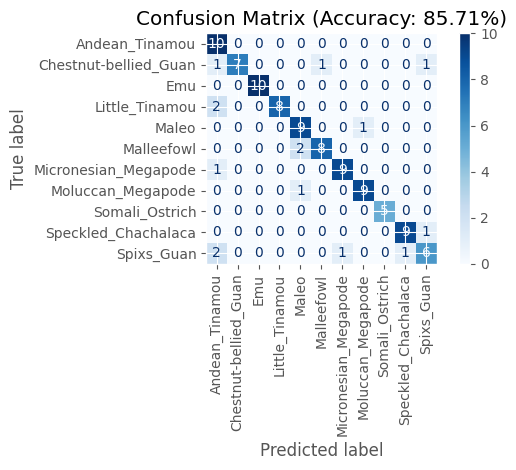

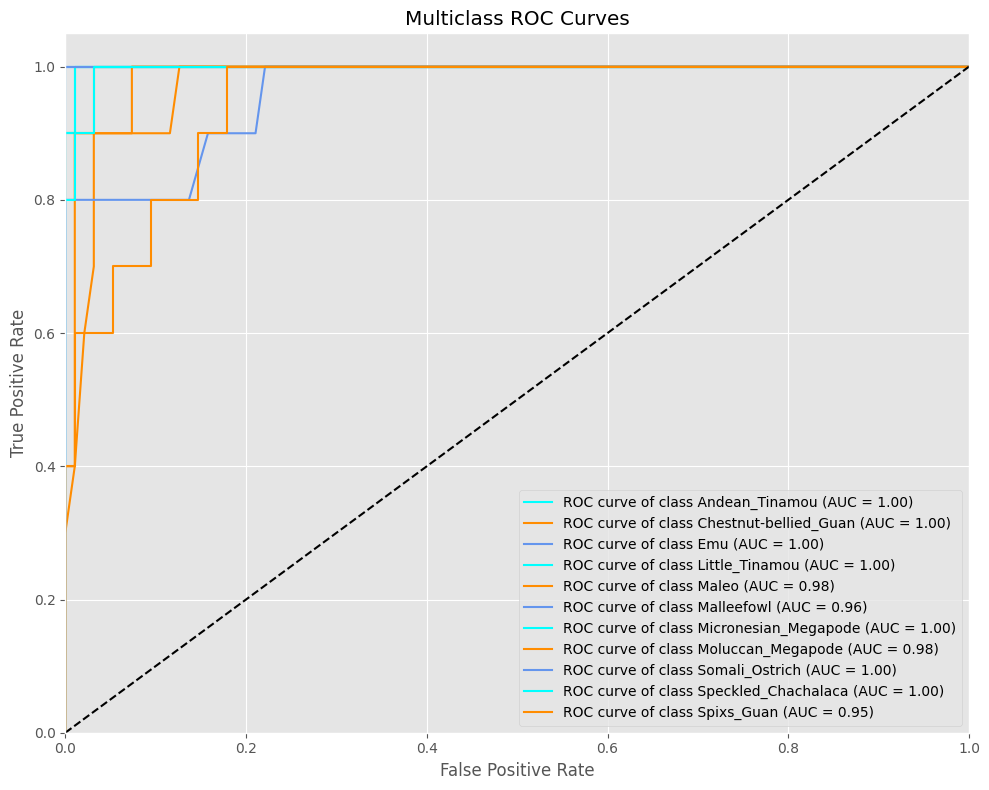


To improve accuracy beyond current performance:
1. Add more training data, especially for classes with low accuracy
2. Try feature engineering (e.g., additional spectral features)
3. Experiment with different kernels or ensemble methods
4. Use class weights to handle imbalanced data
5. Try neural networks if accuracy needs further improvement


ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.

In [11]:
# %% [markdown]
"""
# 🎯 Bird Call Classifier Evaluation Notebook (Fixed Version)
"""

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, ConfusionMatrixDisplay,
                           roc_curve, auc, precision_recall_curve)
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib
from pathlib import Path
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Configuration
BASE_DIR = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_DIR = BASE_DIR / 'data'
FEATURES_DIR = DATA_DIR / 'features'
MODEL_DIR = DATA_DIR / 'models'
MODEL_DIR.mkdir(exist_ok=True, parents=True)

# %% [markdown]
"""
## 📦 Load and Prepare Data
"""

# %%
# Load the features extracted from your previous step
features_df = pd.read_csv(FEATURES_DIR/'bird_features.csv')

# Data Preparation
print(f"Loaded {len(features_df)} samples with {len(features_df.columns)-2} features")

# Separate features and labels
X = features_df.drop(['label', 'source_file'], axis=1)
y = features_df['label']

# Handle missing values if any
X.fillna(X.mean(), inplace=True)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (consistent with your training)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# %% [markdown]
"""
## 🚀 SVM Model Training with RBF Kernel
"""

# %%
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define parameter grid for optimization
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf']
}

# Create and train SVM with grid search
svm = SVC(class_weight='balanced', probability=True)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

print("Training SVM with RBF kernel...")
grid_search.fit(X_train_scaled, y_train)

# Get best model
best_svm = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Save model
joblib.dump(best_svm, MODEL_DIR/'best_svm_model.pkl')
joblib.dump(label_encoder, MODEL_DIR/'label_encoder.pkl')
joblib.dump(scaler, MODEL_DIR/'scaler.pkl')

# %% [markdown]
"""
## 📊 Model Evaluation
"""

# %%
# Predictions
y_pred = best_svm.predict(X_test_scaled)
y_prob = best_svm.predict_proba(X_test_scaled)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d', xticks_rotation=90)
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2%})')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

# ROC Curves (for multiclass)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300)
plt.show()

# %% [markdown]
"""
## 💡 Improvement Suggestions
"""

# %%
print("\nTo improve accuracy beyond current performance:")
print("1. Add more training data, especially for classes with low accuracy")
print("2. Try feature engineering (e.g., additional spectral features)")
print("3. Experiment with different kernels or ensemble methods")
print("4. Use class weights to handle imbalanced data")
print("5. Try neural networks if accuracy needs further improvement")

# Save evaluation metrics
eval_results = {
    'accuracy': accuracy,
    'best_params': grid_search.best_params_,
    'classes': list(label_encoder.classes_)
}
pd.DataFrame(eval_results).to_csv(MODEL_DIR/'evaluation_results.csv', index=False)

print("\n✅ Evaluation complete! Model and results saved in 'models' directory")

Loading and preparing data...

Starting advanced grid search with stacking...
Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
[CV] END knn__n_neighbors=3, rf__max_depth=None, svm_poly__C=0.1, svm_poly__degree=2, svm_poly__gamma=scale, svm_rbf__C=0.1, svm_rbf__gamma=scale; total time=  10.4s
[CV] END knn__n_neighbors=3, rf__max_depth=None, svm_poly__C=0.1, svm_poly__degree=2, svm_poly__gamma=scale, svm_rbf__C=0.1, svm_rbf__gamma=0.1; total time=  10.6s
[CV] END knn__n_neighbors=3, rf__max_depth=None, svm_poly__C=0.1, svm_poly__degree=2, svm_poly__gamma=scale, svm_rbf__C=0.1, svm_rbf__gamma=0.01; total time=  10.6s
[CV] END knn__n_neighbors=3, rf__max_depth=None, svm_poly__C=0.1, svm_poly__degree=2, svm_poly__gamma=scale, svm_rbf__C=0.1, svm_rbf__gamma=0.01; total time=  10.7s
[CV] END knn__n_neighbors=3, rf__max_depth=None, svm_poly__C=0.1, svm_poly__degree=2, svm_poly__gamma=scale, svm_rbf__C=0.1, svm_rbf__gamma=0.01; total time=  10.7s
[CV] END knn__n_neighbors=3, rf_

<Figure size 1400x1200 with 0 Axes>

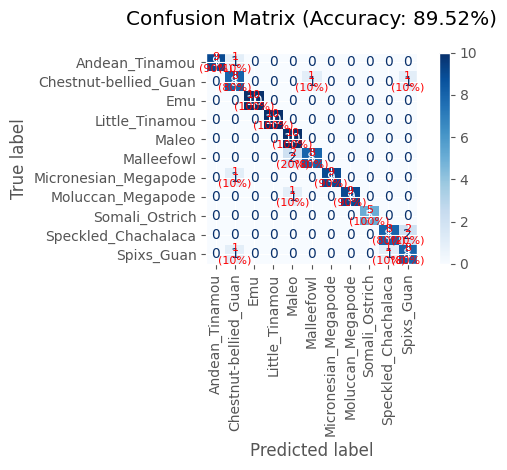


Saving model artifacts...

=== Model Training Complete ===
Best model saved to: /Users/mariaprosgaznares/Desktop/Birdify/models/best_stacked_model.pkl
Final Test Accuracy: 0.8952


In [13]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
from tqdm import tqdm

# Configuration
BASE_DIR = Path.cwd() if 'notebooks' not in str(Path.cwd()) else Path.cwd().parent
DATA_DIR = BASE_DIR / 'data'
FEATURES_PATH = DATA_DIR / 'features' / 'bird_features.csv'
MODEL_DIR = BASE_DIR / 'models'
MODEL_DIR.mkdir(exist_ok=True, parents=True)

# Load and prepare data
print("Loading and preparing data...")
features_df = pd.read_csv(FEATURES_PATH)

# Clean data - remove any rows with missing values
features_df = features_df.dropna()

# Separate features and labels
X = features_df.drop(['label', 'source_file'], axis=1)
y = features_df['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =============================================
# Enhanced Stacking Classifier
# =============================================

# Base models for stacking
base_models = [
    ('svm_rbf', SVC(kernel='rbf', probability=True, class_weight='balanced')),
    ('svm_poly', SVC(kernel='poly', probability=True, class_weight='balanced')),
    ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced')),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]

# Meta model
meta_model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Create stacked model
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=True  # Include original features along with predictions
)

# Parameter grid for optimization
param_grid = {
    'svm_rbf__C': [0.1, 1, 10],
    'svm_rbf__gamma': ['scale', 0.01, 0.1],
    'svm_poly__C': [0.1, 1, 10],
    'svm_poly__gamma': ['scale', 0.01, 0.1],
    'svm_poly__degree': [2, 3],
    'rf__max_depth': [None, 10, 20],
    'knn__n_neighbors': [3, 5, 7]
}

# Grid search with stratified k-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    stacked_model,
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("\nStarting advanced grid search with stacking...")
grid_search.fit(X_train_scaled, y_train)

# Get best model
best_model = grid_search.best_estimator_

# Calibrate the model for better probabilities
print("\nCalibrating model probabilities...")
calibrated_model = CalibratedClassifierCV(best_model, cv=5, method='sigmoid')
calibrated_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = calibrated_model.predict(X_test_scaled)
y_prob = calibrated_model.predict_proba(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)

print("\n=== Best Parameters ===")
print(grid_search.best_params_)
print(f"\n=== Final Test Accuracy: {test_accuracy:.4f} ===")

# Enhanced classification report
print("\n=== Classification Report ===")
print(classification_report(
    y_test, y_pred,
    target_names=label_encoder.classes_))

# Confusion matrix with percentages
plt.figure(figsize=(14, 12))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d', xticks_rotation=90)

# Add percentages
for i in range(len(label_encoder.classes_)):
    for j in range(len(label_encoder.classes_)):
        if cm[i,j] > 0:
            plt.text(j, i, f"{cm[i,j]}\n({cm[i,j]/cm[i].sum():.0%})",
                    ha='center', va='center', color='red', fontsize=8)

plt.title(f'Confusion Matrix (Accuracy: {test_accuracy:.2%})', pad=20)
plt.tight_layout()
plt.savefig(MODEL_DIR/'confusion_matrix.png', dpi=300)
plt.show()

# Save the complete model package
print("\nSaving model artifacts...")
joblib.dump({
    'model': calibrated_model,
    'label_encoder': label_encoder,
    'scaler': scaler,
    'best_params': grid_search.best_params_,
    'test_accuracy': test_accuracy,
    'feature_names': list(X.columns)
}, MODEL_DIR/'best_stacked_model.pkl')

print("\n=== Model Training Complete ===")
print(f"Best model saved to: {MODEL_DIR/'best_stacked_model.pkl'}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")